In [1]:
# This lecture tries to recreate the neural network in the paper 'A Neural Probabilistic Language Model' by Bengio et al.

# It is intuitive to explain that for one input character and one output character, we had a probability matrix of 27 * 27
# which means if we wanted to take two characters as input, and output one character, we would need (27 * 27) * 27
# Which means the probability matrix quickly blows up once you try to increase the ability of the solution. This is the
# curse of dimensionality
# 
# 
# 


import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('names.txt','r').read().splitlines()
words

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn',
 'abigail',
 'emily',
 'elizabeth',
 'mila',
 'ella',
 'avery',
 'sofia',
 'camila',
 'aria',
 'scarlett',
 'victoria',
 'madison',
 'luna',
 'grace',
 'chloe',
 'penelope',
 'layla',
 'riley',
 'zoey',
 'nora',
 'lily',
 'eleanor',
 'hannah',
 'lillian',
 'addison',
 'aubrey',
 'ellie',
 'stella',
 'natalie',
 'zoe',
 'leah',
 'hazel',
 'violet',
 'aurora',
 'savannah',
 'audrey',
 'brooklyn',
 'bella',
 'claire',
 'skylar',
 'lucy',
 'paisley',
 'everly',
 'anna',
 'caroline',
 'nova',
 'genesis',
 'emilia',
 'kennedy',
 'samantha',
 'maya',
 'willow',
 'kinsley',
 'naomi',
 'aaliyah',
 'elena',
 'sarah',
 'ariana',
 'allison',
 'gabriella',
 'alice',
 'madelyn',
 'cora',
 'ruby',
 'eva',
 'serenity',
 'autumn',
 'adeline',
 'hailey',
 'gianna',
 'valentina',
 'isla',
 'eliana',
 'quinn',
 'nevaeh',
 'ivy',
 'sadie',
 'piper',
 'lydia',
 'alexa',
 'josephine',
 'emery',
 'julia'

In [2]:
# Make the items and chars to pull out a non repeating vocabulary of characters from the dataset.
chars = sorted(list(set(''.join(words))))
# make a numeric identifier for each unique character
s2i = {s:i+1 for i,s in enumerate(chars)}
s2i['.'] = 0 # add an identifier which you can use to denote the beginning and end of each character (in the original paper, this is word)

# reverse the order
i2s = {i:s for s,i in s2i.items()} # this switches the key of the dictionary, making numerals identify a character, which is needed for languages.

i2s

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [83]:
# Build a dataset now, where you input three characters, which is fed into the network, giving one output, which is the probable 4th charact4er

block_size = 3 # number of inputs going into the network, i.e., number of characters.
X, Y = [],[] # X is the inputs (block_size in number), while Y is the output, which is one for this example.

for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = s2i[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(i2s[i] for i in context), '---->', i2s[ix])
        #print(context[1:] + [ix])
        context = context[1:] + [ix]

# convert to torch datasets
X = torch.tensor(X)
Y = torch.tensor(Y)


raizel
... ----> r
..r ----> a
.ra ----> i
rai ----> z
aiz ----> e
ize ----> l
zel ----> .
kahlil
... ----> k
..k ----> a
.ka ----> h
kah ----> l
ahl ----> i
hli ----> l
lil ----> .
aanika
... ----> a
..a ----> a
.aa ----> n
aan ----> i
ani ----> k
nik ----> a
ika ----> .
johnna
... ----> j
..j ----> o
.jo ----> h
joh ----> n
ohn ----> n
hnn ----> a
nna ----> .
kincaid
... ----> k
..k ----> i
.ki ----> n
kin ----> c
inc ----> a
nca ----> i
cai ----> d
aid ----> .


In [4]:
# The dataset is now ready. Now let us make the embedding matrix C in the nn diagram of Bengio et al.
# This matrix is an embedding matrix which is a look up table for the input values. It is a nn layer like

C = torch.randn((27,2)) # 2 is random choice as 2 is compressing 27 chars to 2 where the paper has 17000 words to 30

C[5]
# Similar to one hot like below, which does the act of pulling out the 5th row of the matrix C.
#F.one_hot(torch.tensor(5),num_classes=27).float() @ C  # remember one_hot is not a float, please convert it into one before performing operations.

# Can also try the following
C[[5,6,7]]

# Can also try the following
C[torch.tensor([5,6,7])]

# Can also try the following
C[torch.tensor([5,6,9,9,9,9,9])] # can endure repetitions 

# Can also use multidimensional indexing
C[X].shape

# Can also try this to index within the input matrix
C[X][13,2]

tensor([-0.1527, -2.5590])

In [5]:
# embed 
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [15]:
# initialize weights
W1 = torch.randn((6,100)) # 6 is because the network taken in 3 matrices 2d embeddings each at the input, 100 is what we choose
b1 = torch.randn(100) # biases, need only 100 as we have 100 neurons in the hidden layer

# Concatenate the embeddings to fit the matriix calculation

# we want to perform emb @ W1 + b1, but we need to reshape the emb matrix to fit the matrix multiplication
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]],1).shape # this is the desired input to the first layer, with 6 columns
# Can be done by the following
torch.cat(torch.unbind(emb,1),1).shape # this is the desired input to the first layer, with 6 columns. Use unbind to unbind the middle dimension dim 1, then concatenate them along middle dimension, dim 1
# the above is inefficient because it creates a new tensor

# other properties of torch.tensor
a = torch.arange(18)
a.shape
a.view(2,9) # view this 18 column single row array as other sizes so long as the size is conserved.
# view is efficient because it does not change the way the matrix is stored in memory, it just changes the way it is interpreted.


tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [16]:
# we can use this to view our emb, which was a 32,2,3 matrix, as a 32,6 matrix. making it efficient
emb = C[X]
#emb.view(32,6)

In [8]:
# continuing :

h = emb.view(32,6) @ W1 + b1
h

tensor([[ 3.4960, -4.1030, -2.5762,  ...,  3.7070, -2.1887, -2.0855],
        [ 4.2132, -0.9922, -0.5249,  ...,  3.0665, -4.9161,  1.6589],
        [-0.1253,  0.8326,  1.3452,  ...,  0.3107, -3.1349,  2.0632],
        ...,
        [ 3.4272,  1.6664,  1.5736,  ...,  1.6917, -4.0211,  6.2418],
        [-3.2512,  3.9877, -4.5351,  ...,  1.4469, -2.9912,  2.5327],
        [-1.8715,  5.0499, -3.4886,  ...,  3.2974, -0.2041,  2.0700]])

In [19]:
# another convenience is to avoid 32, use -1 to make it generic as pytorch will figure out the size of the first dimension
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # tanh is the activation function
h.shape # the hidden layer of activations is now 32,100. Therefore, 6 inputs, into 32 neurons of first layer, into 100 in hidden layer

torch.Size([32, 100])

In [20]:
# final layer now
W2 = torch.randn(100,27) # takes 100 inputs from the hidden layer and has 27 outputs for each character that can beinferred from i2s
b2 = torch.randn(27) # 27 biases for each character

logits = h @ W2 + b2
logits.shape # 32,27 should bee expected for this example
# apply the softmax to get the probabilities
counts = logits.exp() # not real counts, fake, but the name is kept for consistency
prob = counts/counts.sum(1,keepdim=True)
#logprob = prob.log()
#logprob.shape
prob[torch.arange(32),Y] #So this should give you outputs of probabilitieis for the 32 inputs in Y

# neg log likelihood loss
loss = -prob[torch.arange(32),Y].log().mean()
loss


tensor(18.0618)

In [45]:
# Mature way of rewriting all of the above

# Step 1) Build the dataset
block_size = 3 # number of inputs going into the network, i.e., number of characters.
X, Y = [],[] # X is the inputs (block_size in number), while Y is the output, which is one for this example.

for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = s2i[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(i2s[i] for i in context), '---->', i2s[ix])
        #print(context[1:] + [ix])
        context = context[1:] + [ix]

# convert to torch datasets
X = torch.tensor(X)
Y = torch.tensor(Y)

# Step 2) Build the model
g = torch.Generator().manual_seed(0)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn(100,27,generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]


In [34]:
# Build the layers

emb = C[X]
print(emb.shape)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
print(h.shape)

# 
logits = h @ W2 + b2
counts = logits.exp()
prob = counts/counts.sum(1,keepdim=True)
loss = -prob[torch.arange(len(X)),Y].log().mean()
loss

# The above functions can be combined into a single function, and is already offered as a cross entropy loss function in pytorch
loss = F.cross_entropy(logits,Y)
loss
# As cross-entropy is a fused version of the other operations, it is efficient. Also efficient mathematically as the expression is not clustered

# Cross entropy is also well behaved as our expression may output extreme values like 1e-67. This can be avoided in the implementation of torch's cross-entropy function
# To see this, remove tanh from previous h layer and see that the loss is always inf

for p in parameters:
    p.requires_grad = True # this is to tell pytorch to track the gradients of the parameters
   


torch.Size([32, 3, 2])
torch.Size([32, 100])


In [46]:
 # Step 2) Build the model
g = torch.Generator().manual_seed(0)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn(100,27,generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad = True # this is to tell pytorch to track the gradients of the parameters
  

for _ in range(100):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y)
    print(loss.item())
    for p in parameters:
        p.grad = None # make gradients zero before each iteration
    # update gradients
    loss.backward()
    for p in parameters:
        p.data += -0.1*p.grad # update parameters
    


15.25028133392334
13.771982192993164
12.611047744750977
11.72183609008789
10.989806175231934
10.378765106201172
9.860992431640625
9.41311264038086
9.027737617492676
8.694738388061523
8.40614128112793
8.151901245117188
7.921947956085205
7.709621429443359
7.511196613311768
7.324643611907959
7.148744583129883
6.98243522644043
6.8247456550598145
6.674936294555664
6.532747268676758
6.398221015930176
6.272059917449951
6.155346393585205
6.052409648895264
5.963147163391113
5.899130344390869
5.802715301513672
5.729832172393799
5.595641613006592
5.51395320892334
5.415326118469238
5.346263885498047
5.266387939453125
5.209205627441406
5.133442401885986
5.0825114250183105
5.005342483520508
4.95639181137085
4.882205486297607
4.835662841796875
4.767765998840332
4.72464656829834
4.662685394287109
4.6230010986328125
4.566227912902832
4.529510974884033
4.477639675140381
4.443373203277588
4.396119594573975
4.363893032073975
4.320687294006348
4.290182113647461
4.250380039215088
4.221376419067383
4.1843943

In [47]:
# Check result when only 5 words aare used to build a dataset of 32 ground truths of 3 characters in, and 1 character out

print(Y) # print ground truth
print(logits.argmax(1)) # print predictions, also same as torch.max(logits,1) or logits.max(1)
print(logits.max(1)) # this one gives both the maxc probability and the index value

tensor([ 5, 13, 13,  ..., 26, 24,  0])
tensor([ 1,  1, 25,  ...,  1,  1,  1])
torch.return_types.max(
values=tensor([2.1104, 1.8657, 5.1082,  ..., 8.0650, 8.1630, 7.3822],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1,  1, 25,  ...,  1,  1,  1]))


In [ ]:
# You can see here that the Y values are closely represented by the predictions, but not quire there yet for some characters

# This means in the training set, despite overfitting, the training data sometimes contains ...a and ...e so that makes it difficult to overfit.

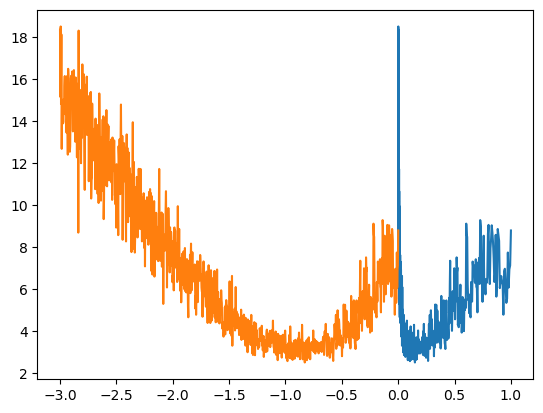

In [61]:
# Let us now introduce the above model estimation using mini batches which speeds up iterations

 # Step 2) Build the model
g = torch.Generator().manual_seed(0)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn(100,27,generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad = True # this is to tell pytorch to track the gradients of the parameters
  
lri = []
lrei = []
lossi = []
niters = 1000
# update weights and biases including the input embedding matrix C
learning_rate_linear = torch.linspace(0.001,1,niters) # this is the example of a linear learning rate between 0.001 and 1, a stable region for the training as was manually observed
learning_rate_exponent = torch.linspace(-3,0,niters)
learning_rate = 10**(learning_rate_exponent) # this defines a learning rate between 0.001 and 1 which is non linearly spaced using the 10** function
    
for i in range(niters):

    # mini batching
    ix = torch.randint(0,X.shape[0],(32,)) # returns 32 randomized instances if integers between 0 and the training set size

    # forward pass
    emb = C[X[ix]] # indexed inserted into inputs X
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y[ix]) # indexes inserted into grount truths in Y
    for p in parameters:
        p.grad = None # make gradients zero before each iteration
    #print(loss.item())
    # backward pass
    loss.backward()

    # the idea in the above is to start with a small number and iterate to converge faster towards the end
    for p in parameters:
        #p.data += -0.01*p.grad # update parameters # -0.00001 is too low. -0.001 is good. -1 is too fast. -10 is unstable and all over the place
        p.data += -learning_rate[i]*p.grad # update paramerters based on iteration based learning rate

    # track stats
    lrei.append(learning_rate_exponent[i])
    lri.append(learning_rate[i])
    lossi.append(loss.item())


 # print tracked stats
 # 
plt.plot(lri,lossi)   
plt.plot(lrei,lossi)
plt.show()


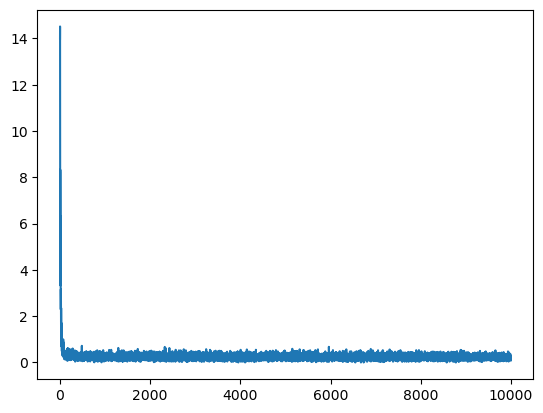

0.1607639491558075


In [95]:
# The above plot shows a nice comfortable minimum for our learning rate at around 0.1
import numpy as np
# Let us now introduce the above model estimation using mini batches which speeds up iterations

 # Step 2) Build the model
g = torch.Generator().manual_seed(0)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn(100,27,generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad = True # this is to tell pytorch to track the gradients of the parameters
  
lossi = []
niters = 10000
# update weights and biases including the input embedding matrix C
    
for i in range(niters):

    # mini batching
    ix = torch.randint(0,X.shape[0],(32,)) # returns 32 randomized instances if integers between 0 and the training set size

    # forward pass
    emb = C[X[ix]] # indexed inserted into inputs X
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Y[ix]) # indexes inserted into grount truths in Y
    for p in parameters:
        p.grad = None # make gradients zero before each iteration
    #print(loss.item())
    # backward pass
    loss.backward()

    # the idea in the above is to start with a small number and iterate to converge faster towards the end
    if i< np.ceil(0.9*niters): # implement a small decay in the later stages to change our learning rate to something slower for better convergence as we see that with 0.1 it starts to plateau quickly
        lr = 0.1
    else:
        lr = 0.01

    for p in parameters:
        #p.data += -0.01*p.grad # update parameters # -0.00001 is too low. -0.001 is good. -1 is too fast. -10 is unstable and all over the place
        p.data += -lr*p.grad # update paramerters based on iteration based learning rate

    # track stats
    lossi.append(loss.item())


 # print tracked stats
 # 
plt.plot(range(niters),lossi)   
plt.show()
print(loss.item())

In [71]:
# estimate total training set loss
emb = C[X] # indexed inserted into inputs X
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Y) # indexes inserted into grount truths in Y
print(loss.item())

2.3966450691223145


In [108]:
# In a more mature implementation, you want to split your data into training set, testing set and test set
# 80%, 10%, 10% would be a good split of the data. This helps you understand if you are overfitting to your own data
# This is because once you start increasing the number of parameters in the hidden layers, your model will
# start to overfit to the training set and you will not be able to generalize to new data. This is why you 
# need to split your data.

import random
size_network=300
lossi = []
lossi_te = []
niters = 200 # total number of iterations
batch_size = 64 # number of instances in each batch
block_size = 4 # number of input blocks. Will be equal to the total characters fed into the network to predict the next character.
characters_input = 32 # number of characters fed into the network
internal_embedding_size= 10 # number of internal number of outputs you want to compress the input into
characters_total = 27 # total number of characters or tokens that represent unique elements of the input database. Here it is 27 because we have 26 letters and a period .


# Step 1) Build the dataset
def build_dataset(words, block_size):
    #block_size = 3 # number of inputs going into the network, i.e., number of characters.
    X, Y = [],[] # X is the inputs (block_size in number), while Y is the output, which is one for this example.

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = s2i[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(i2s[i] for i in context), '---->', i2s[ix])
            #print(context[1:] + [ix])
            context = context[1:] + [ix]

    # convert to torch datasets
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

# Split dataset into training set and test set
random.seed(0)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1],block_size) # training set is 0.8*len words
Xdev, Ydev = build_dataset(words[n1:n2],block_size) # dev set is between 0.8*len words and 0.9*len words
#Xte, Yte = build_dataset(words[n2:]) # test set is 0.9*len words to the end
Xte, Yte = build_dataset(words[n1:],block_size) # test set is 0.8*len words to the end

# The above plot shows a nice comfortable minimum for our learning rate at around 0.1
import numpy as np
# Let us now introduce the above model estimation using mini batches which speeds up iterations


def model(modelsize=size_network,blocksize = block_size,charinsize=characters_input,internalembeddingsize= internal_embedding_size,totalchars=characters_total):
    # Step 2) Build the model
    g = torch.Generator().manual_seed(0)
    C = torch.randn((characters_total,internalembeddingsize),generator=g) # embedding matrix. Will act like one hot encoding for input characters of size 'charinsize=6'
    W1 = torch.randn((blocksize*internalembeddingsize,modelsize),generator=g) # weights from input 'charinsize=6' embedded inputs to hidden layer of output size 'size_network=1000'
    b1 = torch.randn(modelsize,generator=g) # bias for hidden layer
    W2 = torch.randn(modelsize,totalchars,generator=g) # weights from hidden layer to output layer
    b2 = torch.randn(totalchars,generator=g) # bias for output layer
    parameters = [C,W1,b1,W2,b2] # list of parameters to be updated
    for p in parameters:
        p.requires_grad = True # this is to tell pytorch to track the gradients of the parameters
    return parameters, W1, b1, W2, b2, C

parameters, W1, b1, W2, b2, C = model()

print(Xtr.shape,C.shape,W1.shape,W2.shape)


TypeError: build_dataset() missing 1 required positional argument: 'block_size'

In [107]:
emb.view(-1,block_size*internal_embedding_size).shape
emb.shape
Xtr[ix].shape

torch.Size([64, 3])

In [104]:
# Keep this code separate so you don't have to call model again and again and can restart from last saved checkpoint.
# Step 3) Train the model
# update weights and biases including the input embedding matrix C
niters=1000
for i in range(niters):

    # mini batching
    ix = torch.randint(0,Xtr.shape[0],(batch_size,)) # returns 32 randomized instances if integers between 0 and the training set size

    # forward pass
    emb = C[Xtr[ix]] # indexed inserted into inputs X
    h = torch.tanh(emb.view(-1,block_size*internal_embedding_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ytr[ix]) # indexes inserted into grount truths in Y

    

    for p in parameters:
        p.grad = None # make gradients zero before each iteration
    #print(loss.item())
    # backward pass
    loss.backward()

    # the idea in the above is to start with a small number and iterate to converge faster towards the end
    if i< int(0.1*niters): # implement a small decay in the later stages to change our learning rate to something slower for better convergence as we see that with 0.1 it starts to plateau quickly
        lr = 0.1
    else:
        lr = 0.01

    lr = 0.01

    for p in parameters:
        #p.data += -0.01*p.grad # update parameters # -0.00001 is too low. -0.001 is good. -1 is too fast. -10 is unstable and all over the place
        p.data += -lr*p.grad # update paramerters based on iteration based learning rate


    # evaluate test loss too
    emb_te = C[Xte] # indexed inserted into inputs X
    h_te = torch.tanh(emb_te.view(-1,block_size*internal_embedding_size) @ W1 + b1)
    logits_te = h_te @ W2 + b2
    loss_te = F.cross_entropy(logits_te,Yte) # indexes inserted into grount truths in Y
    

    # track stats
    lossi.append(loss.item())
    lossi_te.append(loss_te.item())


 # print tracked stats
 # 


ValueError: Expected input batch_size (48) to match target batch_size (64).

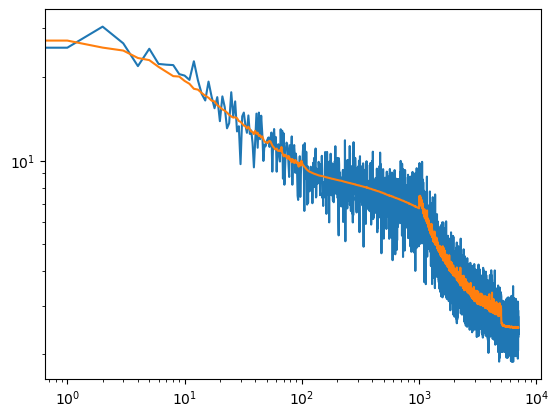

2.4396162033081055


In [95]:
plt.loglog(range(len(lossi)),lossi)   
plt.loglog(range(len(lossi_te)),lossi_te)
plt.show()
print(loss.item())

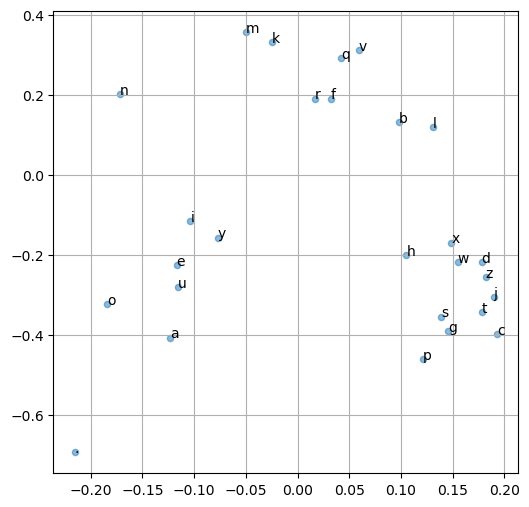

In [40]:
# visualize the embedding matrix for 2 character embedding size
if internal_embedding_size==2: # wont work for higher dimensions
    plt.figure(figsize=(6,6))
    plt.scatter(C[:,0].data,C[:,1].data, s=20, alpha=0.5)
    for i in range(C.shape[0]):
        plt.text(C[i,0].item(),C[i,1].item(),i2s[i],fontsize=10)
    plt.grid('minor')
    plt.show()





In [98]:
# The above figure plots the first column of C versus second column of C, with each 
# character belonging to that row overlaid. If the plot shows that the points are separated,
# then the embedding matrix is doing a good job of separating the characters input into the network.
# It can only be visualized manually for 2 character embedding size. Visualization is possible upto 3 dimensions.

# Now let us try to generate some text using the above model
# Step 4) Generate text
g = torch.Generator().manual_seed(11)

for _ in range(20): # generate 20 samples
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # indexed inserted into inputs X
        h = torch.tanh(emb.view(-1,block_size*internal_embedding_size) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item() # sample from the distribution
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: # If we encounter a . in the prediction, then stop as this would mean it thinks that this would end the sequence
            break
    print(''.join(i2s[i] for i in out)) # join all predictions together and print


oariah.
zerin.
jar.
arho.
liah.
eilrac.
alue.
bariah.
jhelis.
may.
prikgnela.
amori.
ruyi.
yunibrysadj.
lydtrenneli.
jelte.
jaik.
emon.
elli.
elaoian.
